# Monte Carlo Evaluation and Optimization

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import gymnasium as gym
from collections import defaultdict
import sys
import time
from IPython.display import display, clear_output

# Config

In [2]:
CONFIG = {
    'policy_eval':{
        'gamma': 0.99,
        'num_episodes': 500_000,
    },
    'plot_value_fn':{
        'x_lim': (12, 22),
        'y_lim': (1, 11),
        'elev': 20,
        'azim': -120,
        'colorbar': True,
    },
    'on_policy_control':{
        'gamma': 1.0,
        'epsilon': 1.0,
        'epsilon_decay': 0.99995,
        'num_episodes': 500_000,
    },
    'off_policy_control':{
        'gamma': 0.99,
        'num_episodes': 500_000,
    },
    'policy_perf':{
        'num_games': 100_000,
        'verbose': False,
    },
}

## Creating the env

In [3]:
env = gym.make('Blackjack-v1', sab = True, render_mode = 'rgb_array')

## Helper functions

In [4]:
def random_policy(s):
    return np.ones(env.action_space.n)/env.action_space.n

In [5]:
def value_fn_to_array(V):
    obs_space_n = tuple(space.n for space in env.observation_space)
    V_arr = np.zeros(obs_space_n)
    for s,v in V.items():
        V_arr[s[0],s[1],s[2]] = v
    return V_arr

In [6]:
def plot_value_function_3d(V, x_lim = (12, 22), y_lim = (1, 11),elev = 20, azim = -120, colorbar = True):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.view_init(elev=elev, azim=azim)
    
    x = np.arange(*x_lim)
    y = np.arange(*y_lim)
    X, Y = np.meshgrid(x, y, indexing='ij')  
    
    surf = ax.plot_surface(X, Y, V[x_lim[0]:x_lim[1],y_lim[0]:y_lim[1]], cmap='viridis')
    
    if colorbar:
        fig.colorbar(surf)
    
    plt.show()

In [7]:
def print_result(player_hand, dealer_hand):
    
    def card_sum(hand):
        c_sum = sum(hand)
        if 1 in hand and c_sum + 10 <= 21:
            c_sum += 10
        return c_sum
        
    player_total = card_sum(player_hand)
    dealer_total = card_sum(dealer_hand)
    
    print(f"  ➤ Player's hand: {player_hand} (Total: {player_total})"
          + (" 🎯 Blackjack!" if player_total == 21 else ""))
    print(f"  ➤ Dealer's hand: {dealer_hand} (Total: {dealer_total})"
          + (" 🎯 Blackjack!" if dealer_total == 21 else ""))
    print(f"  ➤ Reward: {r} ({'Win' if r > 0 else 'Lose' if r < 0 else 'Draw'})")


def policy_performance_metrics(env, policy, num_games=10_000, verbose = False):
    R = np.empty(num_games, dtype = 'object')
    results = {0.0: 'Draw', 1.0: 'Win', -1.0: 'Loss'}
    for g in range(1, num_games + 1):

        if (g % 100 == 0 or g == num_games) and not verbose:
            print(f'\rGame : {g}/{num_games}',end='')
            sys.stdout.flush()
        
        s, _ = env.reset()
        while True:
            action = np.random.choice(list(range(env.action_space.n)),p = policy(s))
            
            s, r, terminated, truncated, _ = env.step(action)
            if terminated or (truncated and do_truncate):
                break
                
        R[g-1] = results[r]

        if verbose:
            raw_env = env.unwrapped
            print_result(raw_env.player, raw_env.dealer)

    unique, counts = np.unique(R, return_counts=True)
    stats = dict(zip(unique, counts))  
    print('\n')
    print(f"Wins : {100*stats['Win']/num_games}% : 42.22% optimal")
    print(f"Draw : {100*stats['Draw']/num_games}%  : 8.48% optimal")
    print(f"Loss : {100*stats['Loss']/num_games}% : 49.10% optimal")
    return stats

## Monte Carlo Policy Evaluation

In [8]:
def MC_policy_eval(env, policy, gamma = 1.0, num_episodes = 100):
    
    nA = env.action_space.n

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    V = defaultdict(float)

    for ep in range(1,num_episodes+1):

        if ep % 100 == 0 or ep == num_episodes:
            print(f'\rEpisode : {ep}/{num_episodes}', end='')
            sys.stdout.flush()
        
        H = []
        T = 0
        s, _ = env.reset()
        while True:
            T += 1
            a = np.random.choice(list(range(nA)),p = policy(s))
            s_n, r, terminated, truncated, _ = env.step(a)
            H.append({'s': s, 'a':a, 'r':r})
            if terminated or truncated:
                break
            s = s_n

        for t in range(T):
            s = H[t]['s']
            G_t = sum(H[t_n]['r']*(gamma**i) for i,t_n in enumerate(range(t,T)))
            returns_sum[s] += G_t
            returns_count[s] += 1
            V[s] = returns_sum[s]/returns_count[s]

    return V

Episode : 500000/500000


No usable ace


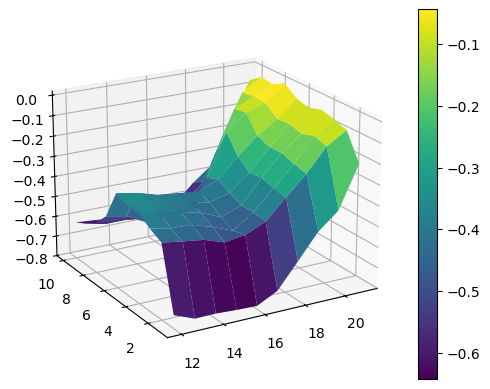

Usable ace


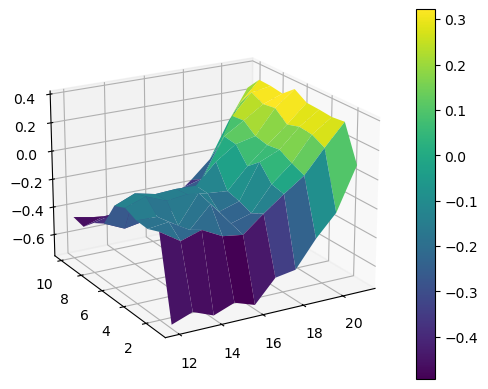

In [9]:
V_eval = MC_policy_eval(env, random_policy, **CONFIG['policy_eval'])

V_arr = value_fn_to_array(V_eval)
V_no_ace = V_arr[:,:,0]
V_usable_ace = V_arr[:,:,1]

print("\n\n\nNo usable ace")
plot_value_function_3d(V_no_ace, **CONFIG['plot_value_fn'])

print("Usable ace")
plot_value_function_3d(V_usable_ace, **CONFIG['plot_value_fn'])

In [10]:
stats = policy_performance_metrics(env, random_policy, **CONFIG['policy_perf'])

Game : 100000/100000

Wins : 28.262% : 42.22% optimal
Draw : 4.116%  : 8.48% optimal
Loss : 67.622% : 49.10% optimal


## On-Policy Monte Carlo Control

In [11]:
def MC_on_policy_control(env, gamma = 1.0, epsilon = 0.0, epsilon_decay = 1.0, num_episodes = 100):

    def get_eps_greedy_policy(Q, epsilon):
        def eps_greedy_policy(s):
            A = np.ones(nA) * epsilon/nA
            best_a = np.argmax(Q[s])
            A[best_a] += 1-epsilon
            return A
        return eps_greedy_policy

    nA = env.action_space.n

    returns_sum = defaultdict(lambda: np.zeros(nA))
    returns_count = defaultdict(lambda: np.zeros(nA))
    Q = defaultdict(lambda: np.zeros(nA))

    policy = get_eps_greedy_policy(Q, epsilon)

    for ep in range(1, num_episodes + 1):

        if ep % 100 == 0 or ep == num_episodes:
            print(f'\rEpisode : {ep}/{num_episodes}', end='')
            sys.stdout.flush()

        H = []
        T = 0
        s, _ = env.reset()
        while True:
            T += 1
            a = np.random.choice(list(range(nA)), p = policy(s))
            s_n, r, terminated, truncated, _ = env.step(a)
            H.append({'s': s, 'a':a, 'r':r})
            if terminated or truncated:
                break
            s = s_n

        for t in range(T):
            s, a = (H[t]['s'], H[t]['a'])
            G_t = sum(H[t_n]['r']*(gamma**i) for i,t_n in enumerate(range(t,T)))
            returns_sum[s][a] += G_t
            returns_count[s][a] += 1
            Q[s][a] = returns_sum[s][a]/returns_count[s][a]

        epsilon *= epsilon_decay
        policy = get_eps_greedy_policy(Q, epsilon)

    return Q, policy

Episode : 500000/500000


No usable ace


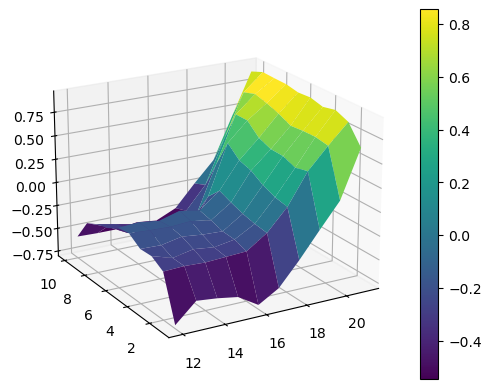

Usable ace


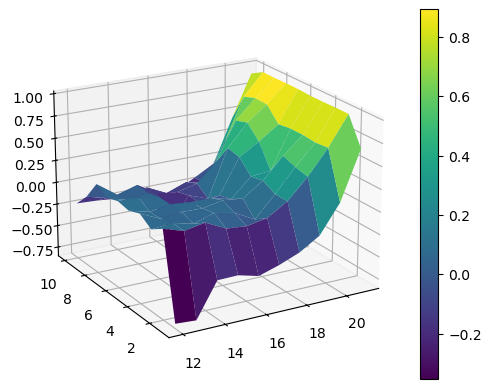

In [12]:
Q_on, on_policy = MC_on_policy_control(env, **CONFIG['on_policy_control']) 

V_on = defaultdict(float)
for s,A in Q_on.items():
    V_on[s] = np.max(A)

V_arr = value_fn_to_array(V_on)
V_no_ace = V_arr[:,:,0]
V_usable_ace = V_arr[:,:,1]

print("\n\n\nNo usable ace")
plot_value_function_3d(V_no_ace, **CONFIG['plot_value_fn'])

print("Usable ace")
plot_value_function_3d(V_usable_ace, **CONFIG['plot_value_fn'])

In [13]:
stats = policy_performance_metrics(env, on_policy, **CONFIG['policy_perf'])

Game : 100000/100000

Wins : 42.686% : 42.22% optimal
Draw : 7.567%  : 8.48% optimal
Loss : 49.747% : 49.10% optimal


## Off-Policy Monte Carlo Control

In [14]:
def MC_off_policy_control(env, behaviour_policy, gamma=1.0, num_episodes=100):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    C = defaultdict(lambda: np.zeros(nA))

    for ep in range(1, num_episodes + 1):
        if ep % 100 == 0 or ep == num_episodes:
            print(f'\rEpisode : {ep}/{num_episodes}', end='')
            sys.stdout.flush()

        H = []
        T = 0
        s, _ = env.reset()
        while True:
            T += 1
            a = np.random.choice(list(range(nA)), p = behaviour_policy(s))
            s_n, r, terminated, truncated, _ = env.step(a)
            H.append({'s': s, 'a':a, 'r':r})
            if terminated or truncated:
                break
            s = s_n

        G = 0
        W = 1.0
        for t in reversed(range(T)):
            s, a, r = (H[t]['s'], H[t]['a'], H[t]['r'])
            G = gamma * G + r
            C[s][a] += W
            Q[s][a] += (W / C[s][a]) * (G - Q[s][a])
            
            if a != np.argmax(Q[s]):
                break
            
            W *= 1.0 / behaviour_policy(s)[a]

    def target_policy(s):
        A = np.zeros(nA)
        A[np.argmax(Q[s])] = 1.0
        return A

    return Q, target_policy


Episode : 500000/500000


No usable ace


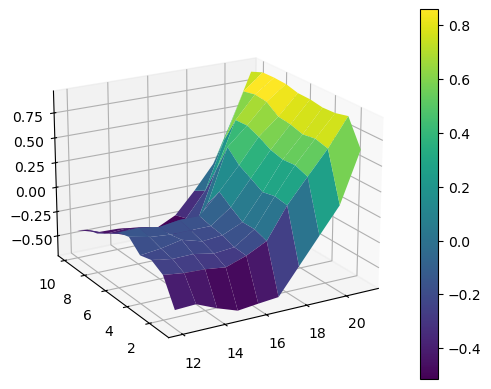

Usable ace


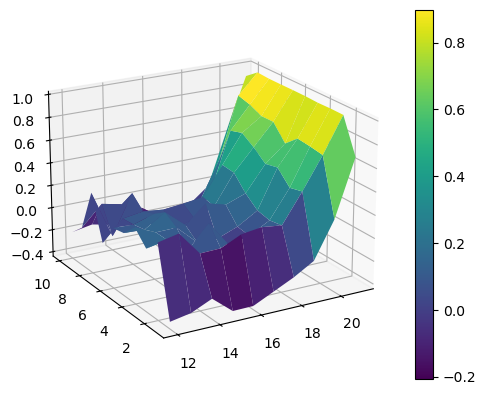

In [15]:
Q_off, off_policy = MC_off_policy_control(env, random_policy, **CONFIG['off_policy_control'])
                                          
V_off = defaultdict(float)
for s,A in Q_off.items():
    V_off[s] = np.max(A)

V_arr = value_fn_to_array(V_off)
V_no_ace = V_arr[:,:,0]
V_usable_ace = V_arr[:,:,1]

print("\n\n\nNo usable ace")
plot_value_function_3d(V_no_ace, **CONFIG['plot_value_fn'])

print("Usable ace")
plot_value_function_3d(V_usable_ace,**CONFIG['plot_value_fn'])

In [16]:
stats = policy_performance_metrics(env, off_policy, **CONFIG['policy_perf'])

Game : 100000/100000

Wins : 43.043% : 42.22% optimal
Draw : 9.135%  : 8.48% optimal
Loss : 47.822% : 49.10% optimal
